<a href="https://colab.research.google.com/github/Aswathyvsajeev/Final-Project-/blob/main/Time_series_Forecasting_models_for_Retail_Sales_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pandas library for importing the data and conducting data analysis
import pandas as pd
#Data visualization module
import matplotlib.pyplot as plt
import numpy as np
#seaborn library for advanced data visualization
import seaborn as sns
# import pacf and acf function to check the autocorrealtion in the dataset
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# import arima function from statsmodels to build ARIMA model 
# from statsmodels.tsa.arima.model import ARIMA
# import function for normal distribution,needed for residual
from scipy.stats import norm
#seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# import exponential smoothing function to build holt-winter's exponential smoothing model.
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
#To remove the warnings import the warnings library
import warnings
warnings.filterwarnings('ignore')
# To evaluate the performance of the model
from statsmodels.tools.eval_measures import rmse
#To determine SARIMA parameters

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importing Dataset

In [ ]:
df_train = pd.read_csv('train.csv',index_col='Date',parse_dates=True,low_memory=False)
df_store = pd.read_csv('store.csv',low_memory=False)

Checking the size of the dataset

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [ ]:
type(df_train.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
df_train.tail()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1
2013-01-01,1115,2,0,0,0,0,a,1


In [ ]:
df_train.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Heatmap to show the missing values in the train dataset

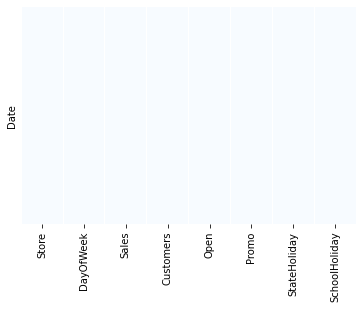

In [ ]:
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='Blues')   # There is no missing values in the dataset.

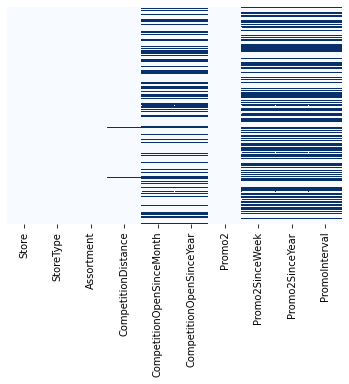

In [ ]:
sns.heatmap(df_store.isnull(),yticklabels=False,cbar=False,cmap='Blues') 

In [ ]:
df_store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [ ]:
# Replacing the 3 missing values in competition distance with mean value.Using median value to replace the missing values since there is skewness in the data
m = df_store['CompetitionDistance'].median()
df_store['CompetitionDistance'] = df_store['CompetitionDistance'].fillna(m)

In [ ]:
#some stores are not participating in promo 2, and there are no competitor stores near some stores .All these values can be replaced by 0.
df_store = df_store.fillna(0)

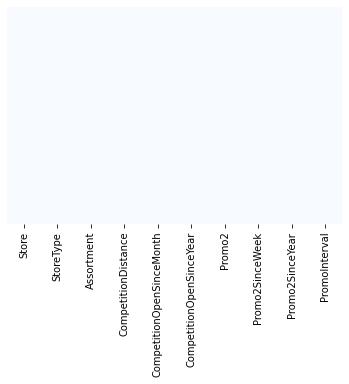

In [ ]:
sns.heatmap(df_store.isnull(),yticklabels=False,cbar=False,cmap='Blues') 

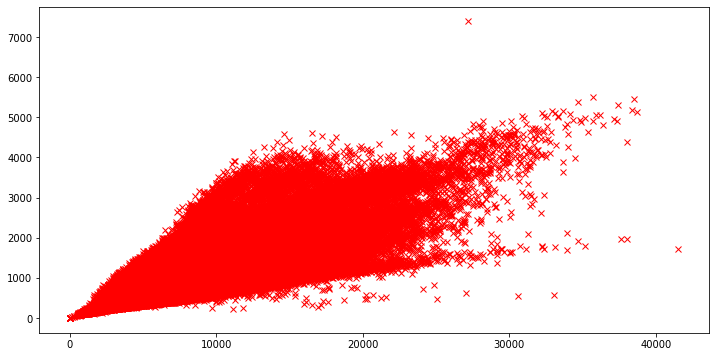

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df_train['Sales'],df_train['Customers'],'x',color='red')

In [ ]:
# Adding New features for EDA 
df_train['year'] = df_train.index.year
df_train['month'] = df_train.index.month
df_train['day'] = df_train.index.day
df_train['week_of_year'] = df_train.index.weekofyear

In [ ]:
# Adding a new variable to the datset which shows the average sales done per customer

df_train['sales_per_customer'] = df_train['Sales']/df_train['Customers']

In [ ]:
df_train.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'year', 'month', 'day', 'week_of_year',
       'sales_per_customer'],
      dtype='object')

In [ ]:
df_train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,year,month,day,week_of_year,sales_per_customer
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,844340.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,2.013832e+03,5.846762e+00,1.570279e+01,2.361551e+01,9.493619
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.773960e-01,3.326097e+00,8.787638e+00,1.443338e+01,2.197494
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,3.000000e+00,8.000000e+00,1.100000e+01,7.895563
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.014000e+03,6.000000e+00,1.600000e+01,2.200000e+01,9.250000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,2.014000e+03,8.000000e+00,2.300000e+01,3.500000e+01,10.899729
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,2.015000e+03,1.200000e+01,3.100000e+01,5.200000e+01,64.957854


In [ ]:
#Rename the dataframe name 
df_train_store = pd.merge(df_train,df_store,how = 'inner' ,on = 'Store')

Analysisng average sales per month

Text(0.5, 1.0, 'Average customers per month')

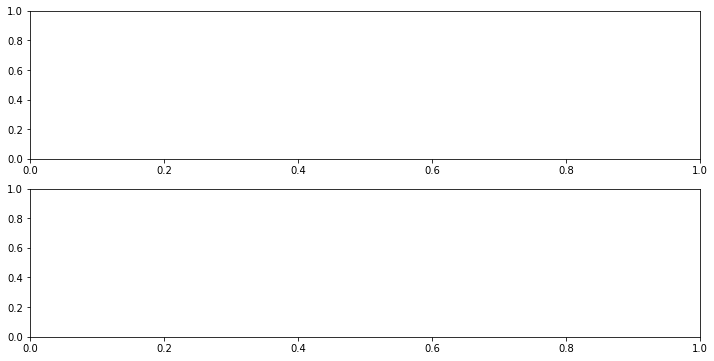

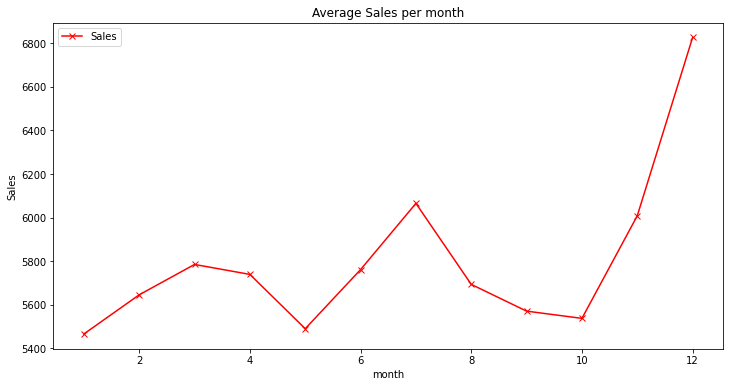

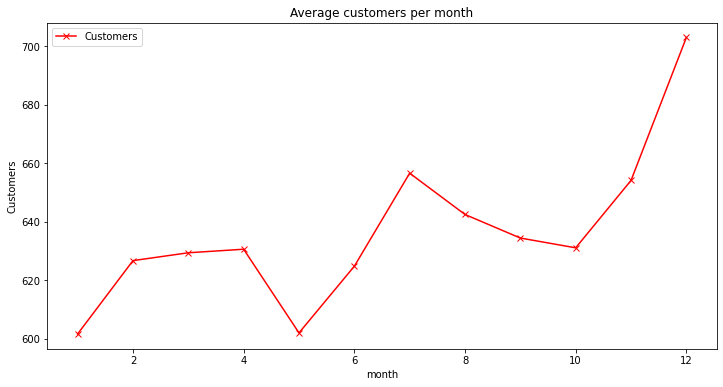

In [ ]:
fig,axis = plt.subplots(2,1,figsize=(12,6));
axis[0]=df_train_store.groupby('month')[['Sales']].mean().plot(marker='x',figsize=(12,6),color='red');
plt.ylabel("Sales");
plt.title("Average Sales per month")
axis[1]=df_train_store.groupby('month')[['Customers']].mean().plot(marker='x',figsize=(12,6),color='red');
plt.ylabel("Customers");
plt.title("Average customers per month")

Let's analyse the average sales and customers per days in week

Text(0.5, 1.0, 'Customers per day')

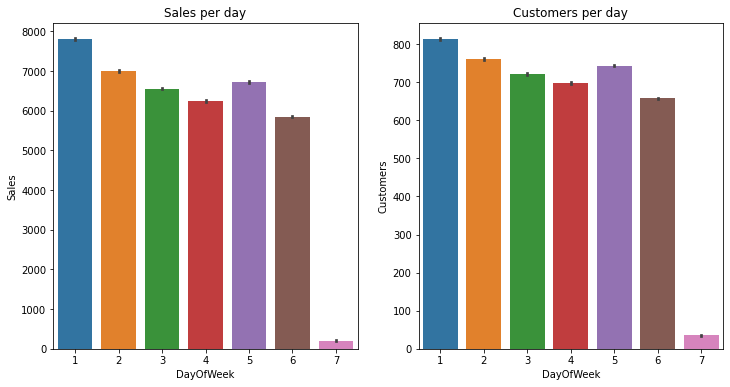

In [ ]:
fig,(axis1,axis2) = plt.subplots(1,2,figsize=(12,6));
sns.barplot(data =df_train_store, x ='DayOfWeek',y='Sales',ax=axis1).set_title("Sales per day")

sns.barplot(data =df_train_store, x ='DayOfWeek',y='Customers',ax=axis2).set_title("Customers per day")

Avergae Sales and customers per year 

Text(0.5, 1.0, 'Customers per year')

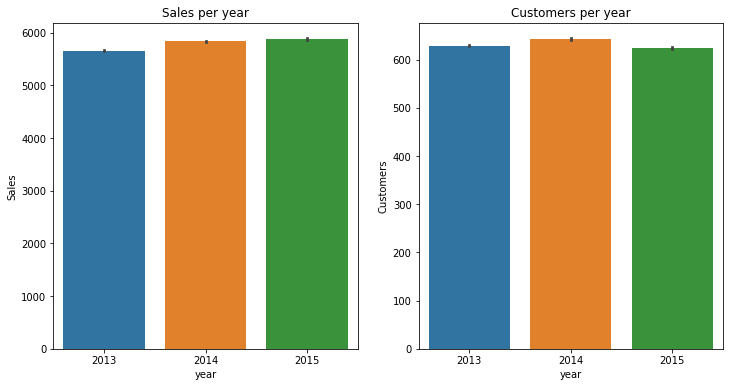

In [ ]:
fig,(axis1,axis2) = plt.subplots(1,2,figsize=(12,6));
sns.barplot(data =df_train_store, x ='year',y='Sales',ax=axis1).set_title("Sales per year")
sns.barplot(data =df_train_store, x ='year',y='Customers',ax=axis2).set_title("Customers per year")

Text(0.5, 1.0, 'Customers visit with and without promo')

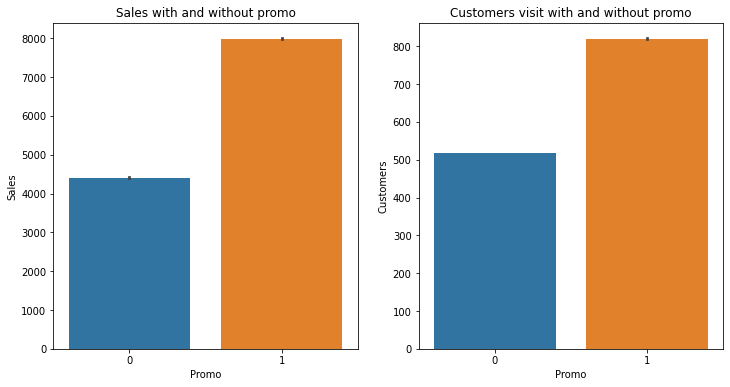

In [ ]:
fig,(axis1,axis2) = plt.subplots(1,2,figsize=(12,6));
sns.barplot(data =df_train_store, x ='Promo',y='Sales',ax=axis1).set_title("Sales with and without promo")
sns.barplot(data =df_train_store, x ='Promo',y='Customers',ax=axis2).set_title("Customers visit with and without promo")

Text(0.5, 0, 'Store type')

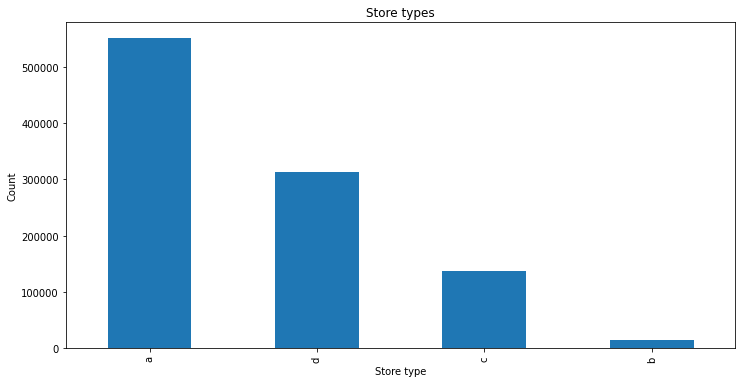

In [ ]:
plt.figure(figsize=(12,6))
df_train_store['StoreType'].value_counts().plot(kind='bar')
plt.title("Store types")
plt.ylabel("Count")
plt.xlabel("Store type")

In [ ]:
t = df_train_store.groupby('StoreType')['Customers', 'Sales'].sum().sort_values('Sales', ascending='desc')

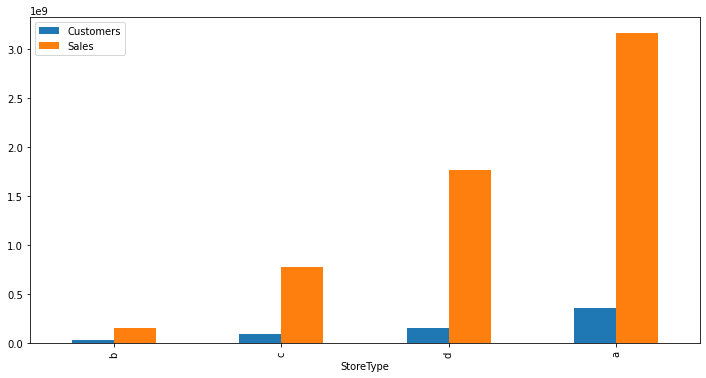

In [ ]:
t.plot(kind='bar',figsize=(12,6))

Sales trend in stores

<Figure size 720x288 with 0 Axes>

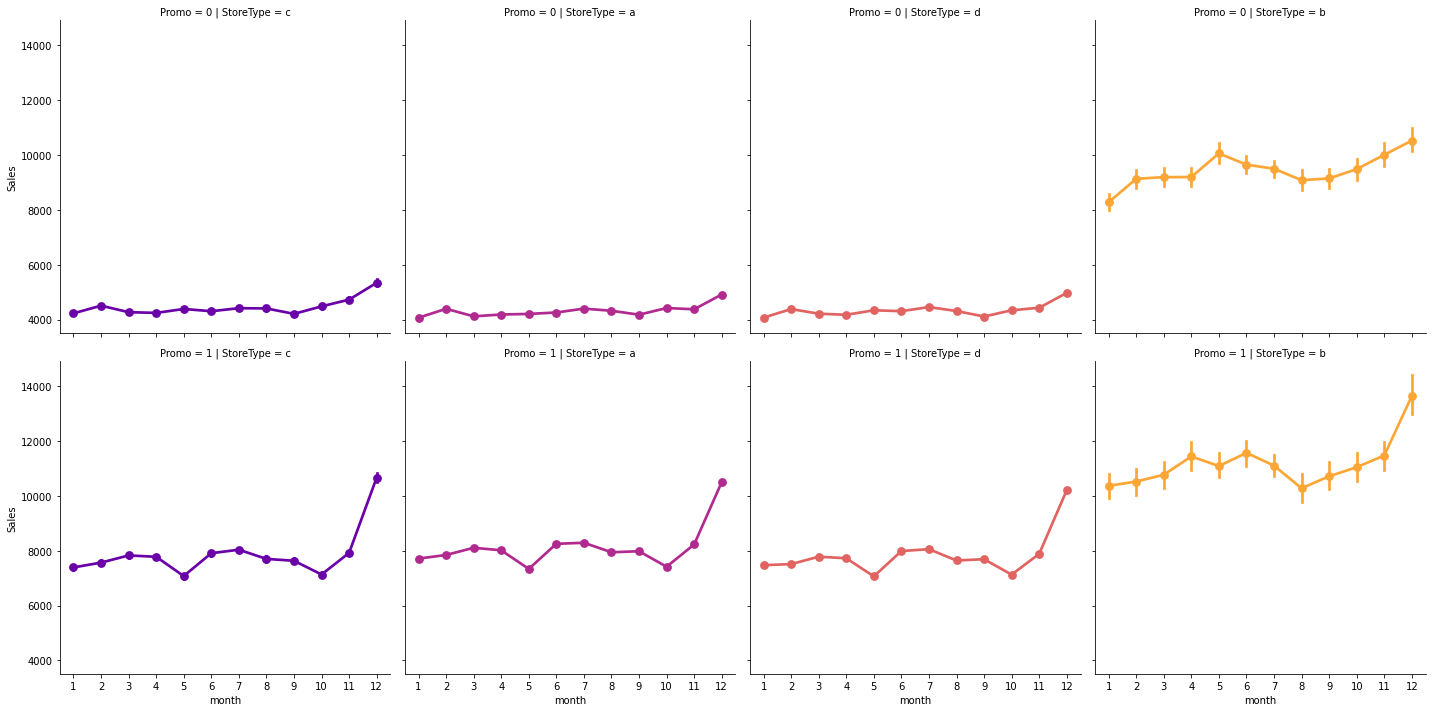

In [ ]:
plt.figure(figsize=(10,4))
sns.factorplot(x ='month',y ='Sales',data=df_train_store,col='StoreType',hue = 'StoreType',row='Promo',palette = 'plasma')

In [ ]:
df_train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


<Figure size 864x432 with 0 Axes>

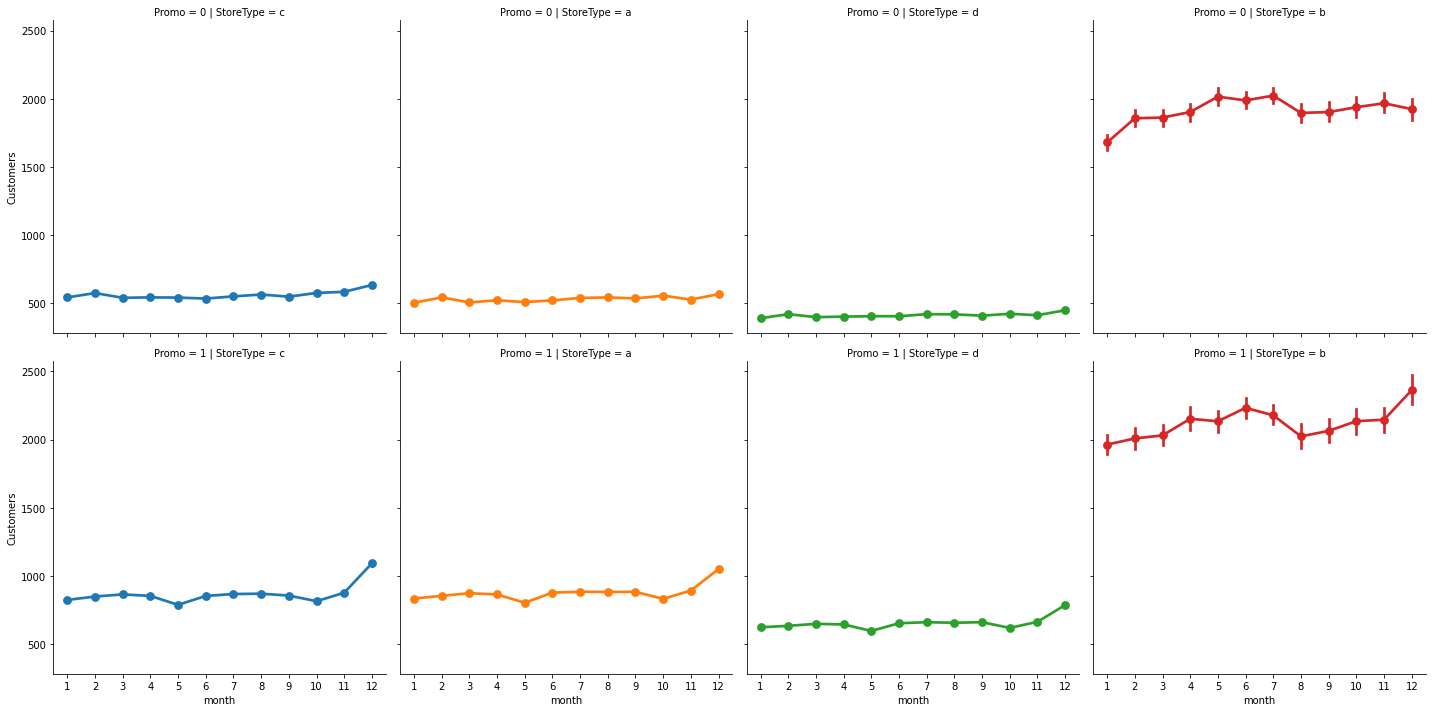

In [ ]:
plt.figure(figsize=(12,6))
sns.factorplot(x ='month',y ='Customers',data=df_train_store,col='StoreType',hue = 'StoreType',row='Promo')

<Figure size 1008x288 with 0 Axes>

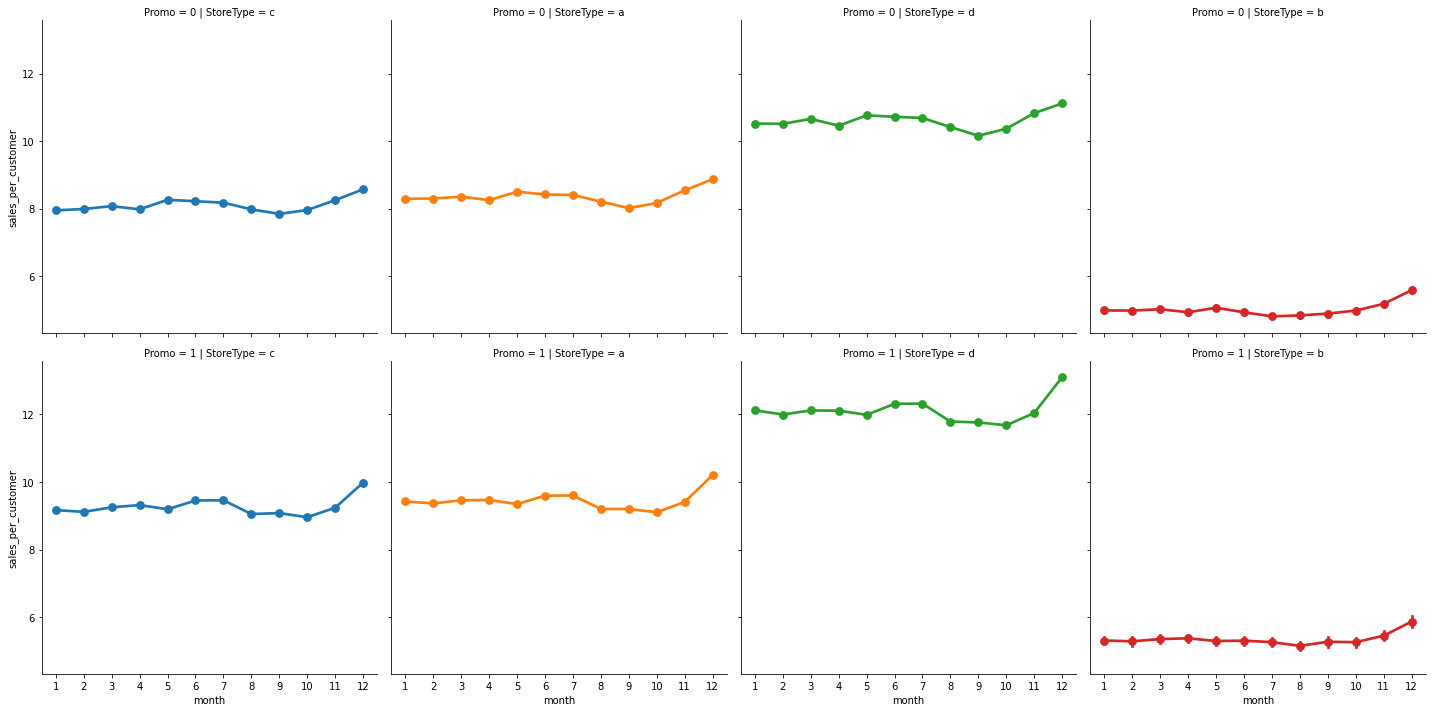

In [ ]:
plt.figure(figsize=(14,4))
sns.factorplot(x ='month',y ='sales_per_customer',data=df_train_store,col='StoreType',hue = 'StoreType',row='Promo')

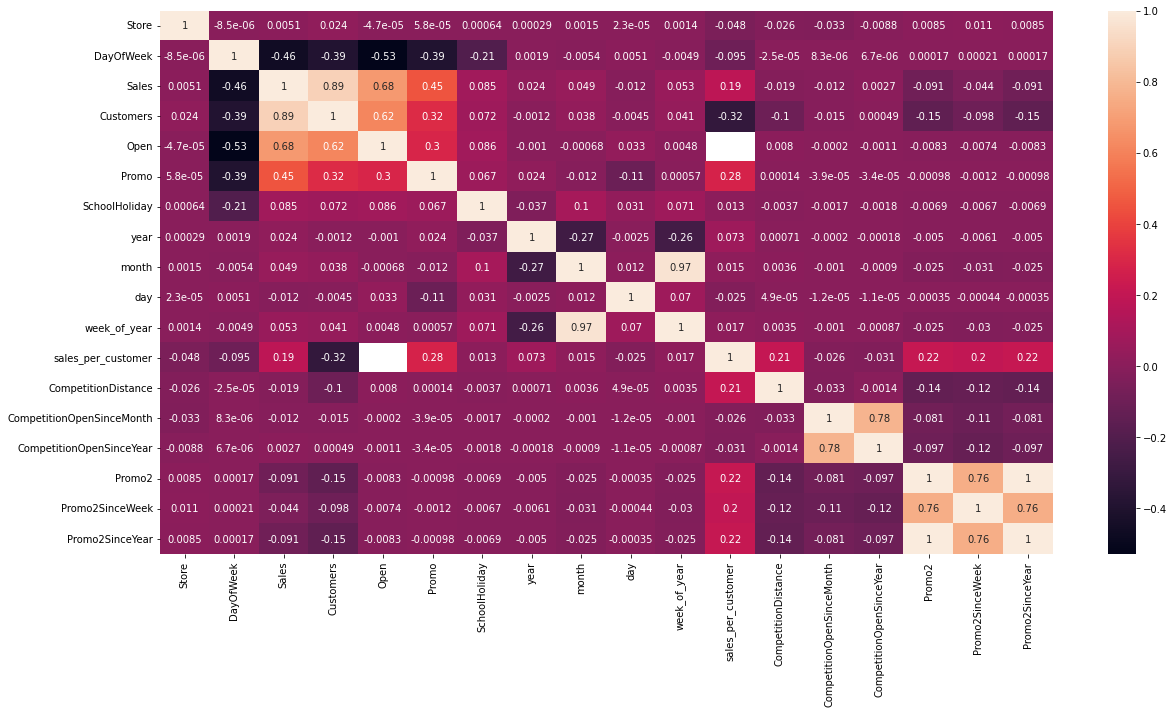

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_train_store.corr(), annot=True)

TIME _SERIES ANALYSIS

We have daily data ,let's resample it to have weekly data with time resamping

Let's take one store from all the 4 store type to represent that store

In [ ]:
df_train = df_train[(df_train['Open']==1)&(df_train['Sales']!=0)]

In [ ]:
df_train['Sales'] = df_train['Sales'] *1.0

In [ ]:
train_sale_a = df_train[df_train['Store']==2]['Sales']
train_sale_b = df_train[df_train['Store']==85]['Sales']
train_sale_c = df_train[df_train['Store']==1]['Sales']
train_sale_d = df_train[df_train['Store']==13]['Sales']

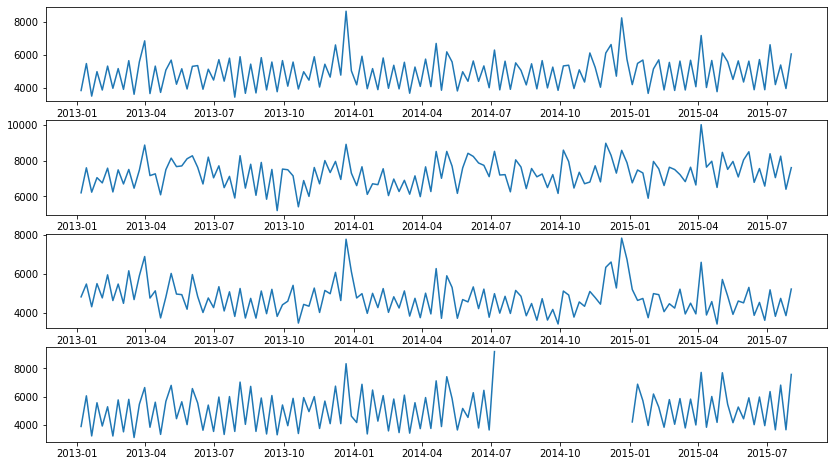

In [ ]:
fig,axis = plt.subplots(4,1,figsize=(14,8))
t =train_sale_a.resample(rule = 'W').mean()#plot(title = "Average sales in every month for 2013-2015")
axis[0].plot(t)
t1 = train_sale_b.resample(rule = 'W').mean()#plot(title = "Average sales in every month for 2013-2015")
axis[1].plot(t1)
t3 = train_sale_c.resample(rule = 'W').mean()#plot(title = "Average sales in every month for 2013-2015")
axis[2].plot(t3)
t4 =train_sale_d.resample(rule = 'W').mean()#plot(title = "Average sales in every month for 2013-2015")
axis[3].plot(t4)

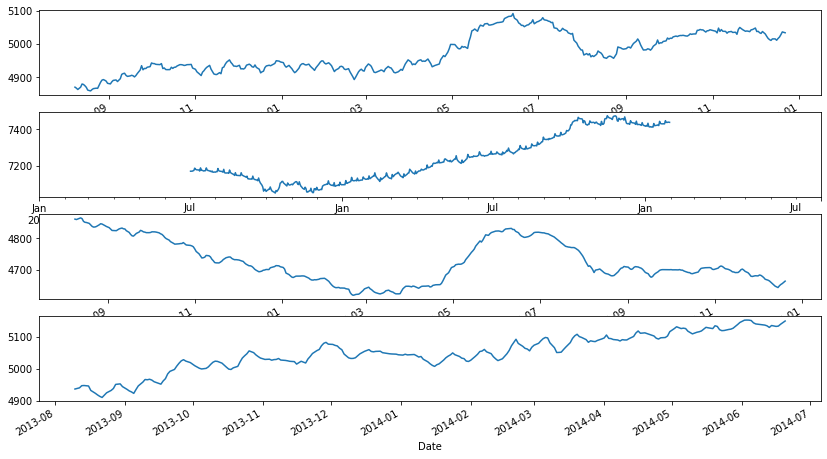

In [ ]:
fig,(axis1,axis2,axis3,axis4) = plt.subplots(4,1,figsize=(14,8))
decompo_a = seasonal_decompose(train_sale_a,model = 'additive',freq=365)
decompo_a.trend.plot(ax= axis1)
decompo_b = seasonal_decompose(train_sale_b,model = 'additive',freq=365)
decompo_b.trend.plot(ax= axis2)
decompo_c = seasonal_decompose(train_sale_c,model = 'additive',freq=365)
decompo_c.trend.plot(ax= axis3)
decompo_d = seasonal_decompose(train_sale_d,model = 'additive',freq=365)
decompo_d.trend.plot(ax= axis4)

Let's conduct test to do the stationarity of the data I will bw using statsmodels library for all the traditional time series mod #Augmented Dickey-Fuller test for cheking the stationarity of the dataset we need to import adfuller function from statsmodels library

In [ ]:

def dickey_fuller_test(timeseries):
  from statsmodels.tsa.stattools import adfuller
  print("Below are the results of dickey-filler test:")
  test = adfuller(timeseries,autolag = "AIC")
  output = pd.Series(test[0:4],index = ["test statistic","p-value","lages used","number of observations used"])
  print(output)

In [ ]:
print("Below are the stationarity test result for store type a: ")
dickey_fuller_test(train_sale_a)

Below are the stationarity test result for store type a: 
Below are the results of dickey-filler test:
test statistic                  -5.292708
p-value                          0.000006
lages used                      17.000000
number of observations used    766.000000
dtype: float64


In [ ]:
print("Below are the stationarity test result for store type b:")
dickey_fuller_test(train_sale_b)

Below are the stationarity test result for store type b:
Below are the results of dickey-filler test:
test statistic                  -5.589202
p-value                          0.000001
lages used                      22.000000
number of observations used    919.000000
dtype: float64


In [ ]:
print("Below are the stationarity test result for store type c:")
dickey_fuller_test(train_sale_c)

Below are the stationarity test result for store type b:
Below are the results of dickey-filler test:
test statistic                  -5.412786
p-value                          0.000003
lages used                      13.000000
number of observations used    767.000000
dtype: float64


In [ ]:
print("Below are the stationarity test result for store type d:")
dickey_fuller_test(train_sale_d)   

Below are the stationarity test result for store type b:
Below are the results of dickey-filler test:
test statistic                -6.321001e+00
p-value                        3.066380e-08
lages used                     1.200000e+01
number of observations used    6.080000e+02
dtype: float64


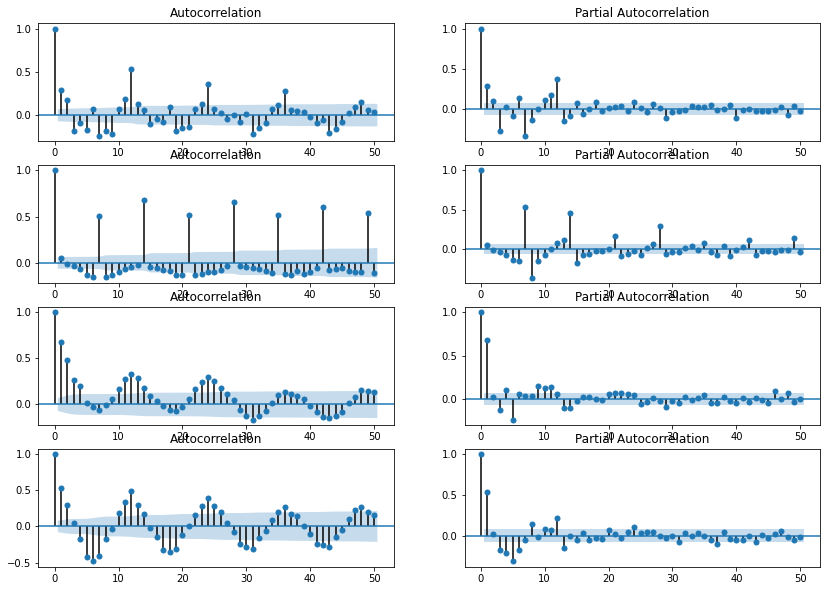

In [ ]:
#import ACF and PACF function from statsmodel library to create ACF and PACF plots
fig = plt.figure(figsize=(14,10))

ax1 = fig.add_subplot(421)
fig = plot_acf(train_sale_a,lags=50,ax = ax1)
ax2 = fig.add_subplot(422)
fig = plot_pacf(train_sale_a,lags=50,ax = ax2)

ax3 = fig.add_subplot(423)
fig = plot_acf(train_sale_b,lags=50,ax = ax3)
ax4 = fig.add_subplot(424)
fig = plot_pacf(train_sale_b,lags=50,ax = ax4)

ax5 = fig.add_subplot(425)
fig = plot_acf(train_sale_c,lags=50,ax = ax5)
ax6 = fig.add_subplot(426)
fig = plot_pacf(train_sale_c,lags=50,ax = ax6)

ax7 = fig.add_subplot(427)
fig = plot_acf(train_sale_d,lags=50,ax = ax7)
ax8 = fig.add_subplot(428)
fig = plot_pacf(train_sale_d,lags=50,ax = ax8)

In [ ]:
train_arima= train_sale_a.resample(rule='MS').mean()


In [ ]:
train_arima.shape

(31,)

In [ ]:
#train_arima= df_train[['Sales']]

Store Type A

In [ ]:
model = SARIMAX(train_arima,order = (5,1,3),seasonal_order = (1,1,0,12))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(5, 1, 3)x(1, 1, 0, 12)   Log Likelihood                -114.898
Date:                            Wed, 05 Jan 2022   AIC                            249.796
Time:                                    18:29:41   BIC                            258.699
Sample:                                01-01-2013   HQIC                           251.023
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4653      3.474     -0.422      0.673      -8.274       5.344
ar.L2         -1.2644      5.279     -0.240      0.811     -11.611       9.082
ar.L3         -1.3363      4.805     -0.278      0.781     -10.753       8.080
ar.L4         -0.7954      5.206     -0.153      0.879     -11.000       9.409
ar.L5          0.0602      3.257      0.018      0.985      -6.323       6.443
ma.L1         -0.0951      4.616     -0.021      0.984      -9.142       8.951
ma.L2         -0.5509      1.758     -0.313      0.754      -3.997       2.895
ma.L3          0.3142      2.605      0.121      0.904      -4.792       5.420
ar.S.L12      -0.7919      0.296     -2.673      0.008      -1.372      -0.211
sigma2      4740.9330   7577.728      0.626      0.532   -1.01e+04    1.96e+04
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.37
Prob(Q):                               nan   Prob(JB):                         0.83
Heteroskedasticity (H):               0.09   Skew:                            -0.35
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

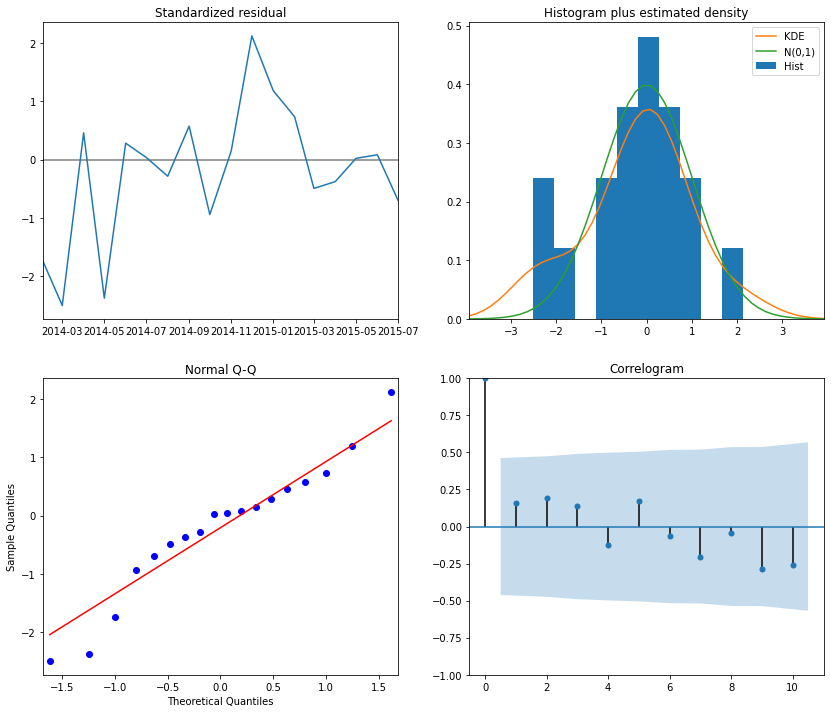

In [ ]:

result.plot_diagnostics(figsize=(14,12))
plt.show()

In [ ]:
pred_arima = result.get_prediction(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2015-07-01'),dynamic = False) 

In [ ]:
#pred_i = pred_arima.conf_int() 

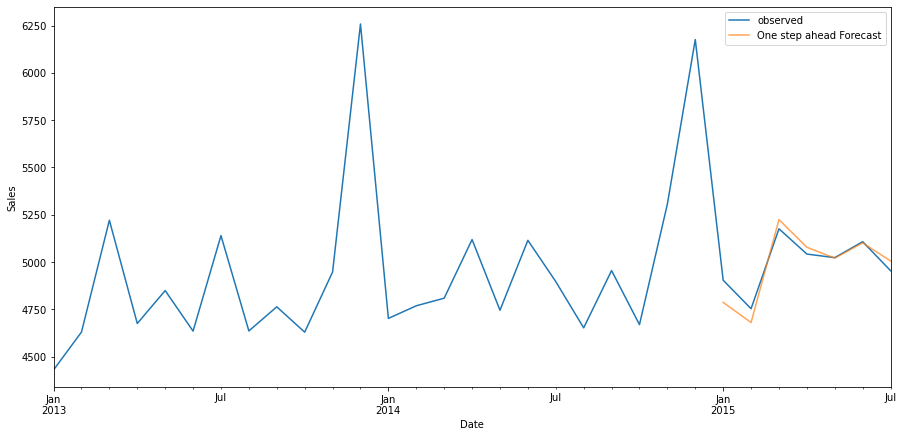

In [ ]:
ax = train_arima["2013":].plot(label = "observed", figsize=(15, 7))
pred_arima.predicted_mean.plot(ax = ax, label = "One step ahead Forecast", alpha = 0.7)
#ax.fill_between(pred_i.index, 
               #pred_i.iloc[:, 0], 
                #pred_i.iloc[:, 1], 
                #color = "k", alpha = 0.2)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend()
plt.show()

arima_forecasted = pred_arima.predicted_mean
arima_truth =  train_arima["2015-01-1":"2015-07-01"]

In [ ]:
pred_future = result.get_forecast(steps=12)

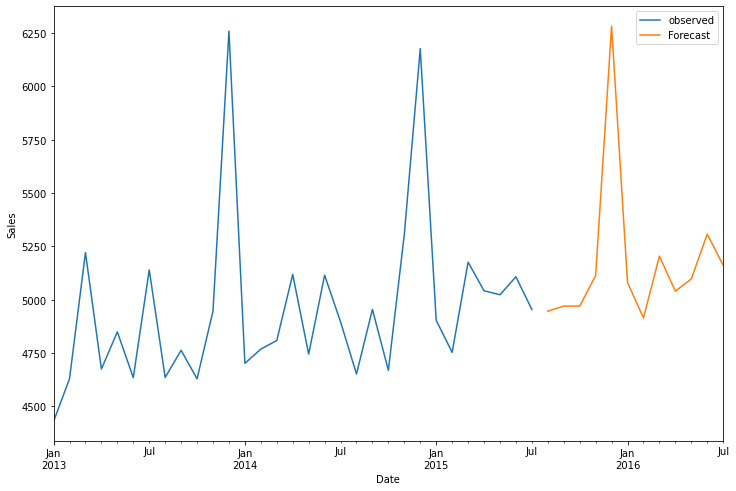

In [ ]:
pred_ci = pred_future.conf_int()
future_a = train_arima.plot(label='observed', figsize=(12, 8))
pred_future.predicted_mean.plot(ax=future_a , label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
future_a .set_xlabel('Date')
future_a .set_ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
from math import sqrt
#from sklearn.metrics import mean_squared_error, r2_score
#rms_arima = sqrt(mean_squared_error(arima_forecasted, arima_truth))
rms_arima = np.sqrt(((arima_forecasted - arima_truth) ** 2).mean())
print("Root mean squared error value is {}". format(rms_arima ))

Root mean squared error value is 60.19166449225591


In [ ]:
r2 = r2_score(arima_forecasted, arima_truth)
print("R squared value is {}". format(r2))

R squared value is 0.8771059940160535


In [ ]:

mse_error = mean_squared_error(arima_forecasted, arima_truth)
print("mean squared value is {}". format(mse_error))

mean squared value is 3786.2729625501224


In [ ]:
mape = np.mean(np.abs((arima_truth - arima_forecasted)/arima_truth))*100
print(mape)

0.9685642694287058


Store Type B

In [ ]:
train_arima_b= train_sale_b.resample(rule='MS').mean()

In [ ]:
model_b = SARIMAX(train_arima_b,order = (3,2,3),seasonal_order = (1,1,0,12))
result_b = model_b.fit()
result_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(3, 2, 3)x(1, 1, 0, 12)   Log Likelihood                -130.080
Date:                            Wed, 05 Jan 2022   AIC                            276.159
Time:                                    18:30:40   BIC                            282.825
Sample:                                01-01-2013   HQIC                           276.822
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0302      0.453     -2.275      0.023      -1.918      -0.143
ar.L2         -0.4912      0.486     -1.012      0.312      -1.443       0.461
ar.L3         -0.2037      0.473     -0.430      0.667      -1.131       0.724
ma.L1          0.5311      0.848      0.626      0.531      -1.131       2.193
ma.L2         -0.2634      0.623     -0.423      0.673      -1.485       0.958
ma.L3         -0.8339      1.060     -0.787      0.431      -2.912       1.244
ar.S.L12      -0.2508      0.491     -0.511      0.610      -1.213       0.712
sigma2      1.989e+05   2.85e+05      0.698      0.485    -3.6e+05    7.58e+05
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.34
Prob(Q):                               nan   Prob(JB):                         0.84
Heteroskedasticity (H):               0.62   Skew:                             0.24
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

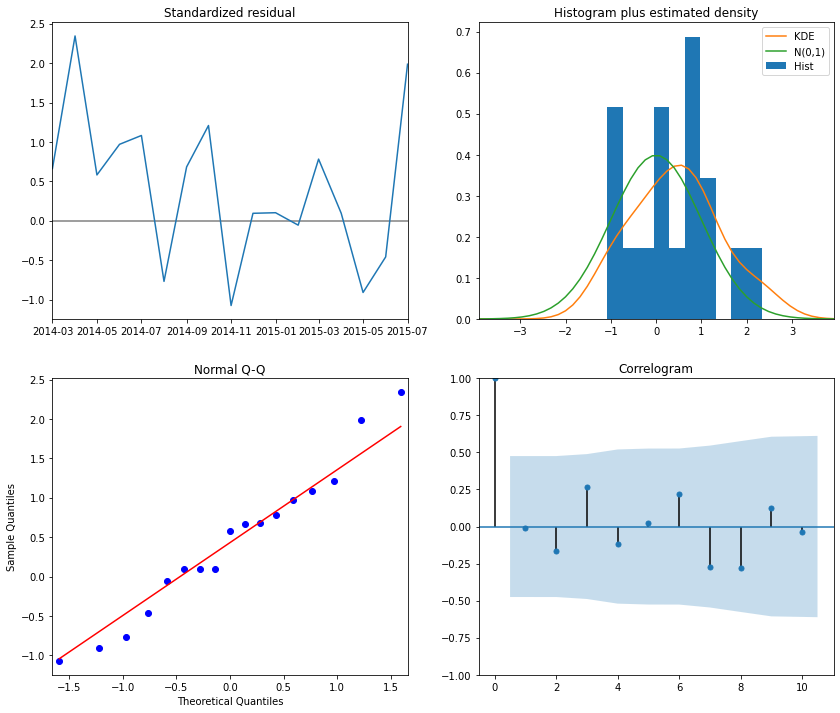

In [ ]:
result_b.plot_diagnostics(figsize=(14,12))
plt.show()

In [ ]:
pred_arima_b = result_b.get_prediction(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2015-07-01'),dynamic = False) 

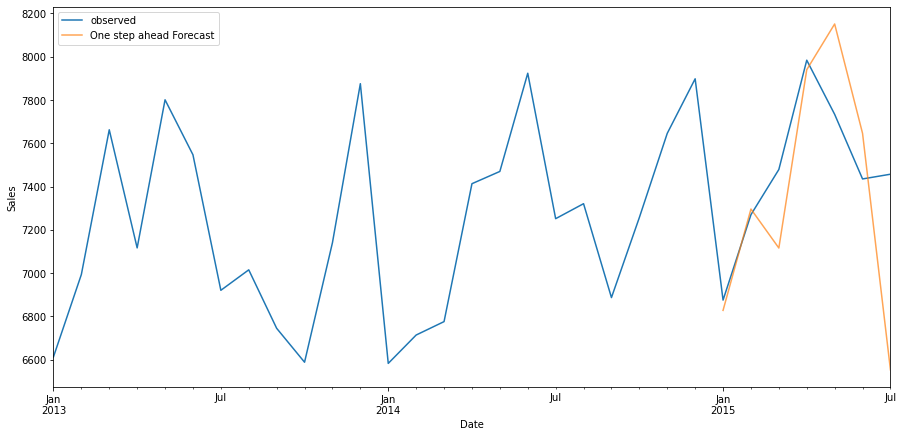

In [ ]:
ax = train_arima_b["2013":].plot(label = "observed", figsize=(15, 7))
pred_arima_b.predicted_mean.plot(ax = ax, label = "One step ahead Forecast", alpha = 0.7)
#ax.fill_between(pred_i.index, 
               #pred_i.iloc[:, 0], 
                #pred_i.iloc[:, 1], 
                #color = "k", alpha = 0.2)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend()
plt.show()

arima_forecasted_b = pred_arima_b.predicted_mean
arima_truth_b =  train_arima_b["2015-01-1":"2015-07-01"]

In [ ]:
pred_future_b = result_b.get_forecast(steps=12)

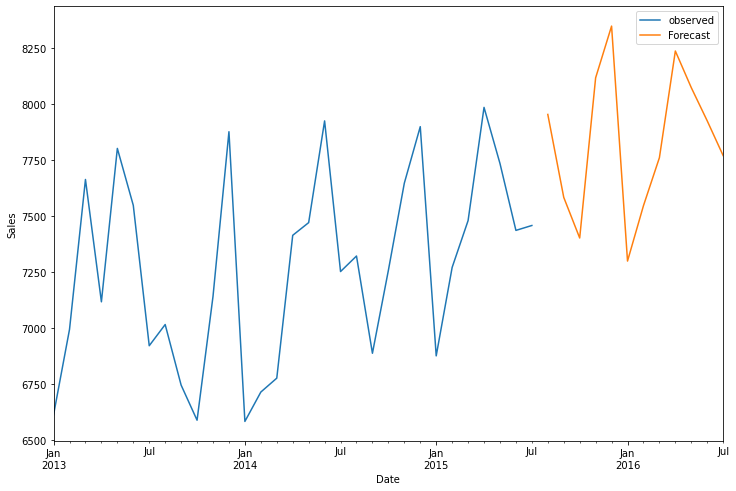

In [ ]:
pred_ci = pred_future_b.conf_int()
future_b = train_arima_b.plot(label='observed', figsize=(12, 8))
pred_future_b.predicted_mean.plot(ax=future_b , label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
future_b .set_xlabel('Date')
future_b .set_ylabel('Sales')
plt.legend()
plt.show()

In [ ]:

mse_error = mean_squared_error(arima_forecasted_b, arima_truth_b)
print("mean squared value is {}". format(mse_error))

mean squared value is 108743.49399215107


In [ ]:
#rms_arima_b = sqrt(mean_squared_error(arima_forecasted_b, arima_truth_b))
#print("Root mean squared error value is {}". format(rms_arima_b))

In [ ]:
rms_arima_b = np.sqrt(((arima_forecasted_b - arima_truth_b) ** 2).mean())
print("Root mean squared error value is {}". format(rms_arima_b))

Root mean squared error value is 409.26635234668015


In [ ]:
mape_b = np.mean(np.abs((arima_truth_b - arima_forecasted_b)/arima_truth_b))*100
print(mape_b)

3.8292765857874036


Store Type C

In [ ]:
train_arima_c= train_sale_c.resample(rule='MS').mean()

In [ ]:
auto_arima(train_arima_c,seasonal=True,m=12).summary()

In [ ]:
model_c = SARIMAX(train_arima_c,order = (2,1,2),seasonal_order = (1,1,0,12))
result_c = model_c.fit()
result_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood                -131.381
Date:                            Wed, 05 Jan 2022   AIC                            274.763
Time:                                    18:31:13   BIC                            280.105
Sample:                                01-01-2013   HQIC                           275.499
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3043      0.354     -0.860      0.390      -0.998       0.389
ar.L2          0.4954      0.228      2.177      0.029       0.049       0.941
ma.L1         -0.3243      0.509     -0.637      0.524      -1.323       0.674
ma.L2         -0.6757      0.436     -1.549      0.121      -1.531       0.179
ar.S.L12      -0.0685      0.381     -0.180      0.857      -0.815       0.678
sigma2       1.11e+05   4.45e-06   2.49e+10      0.000    1.11e+05    1.11e+05
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.31
Prob(Q):                               nan   Prob(JB):                         0.86
Heteroskedasticity (H):               0.10   Skew:                            -0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.1e+26. Standard errors may be unstable.
"""

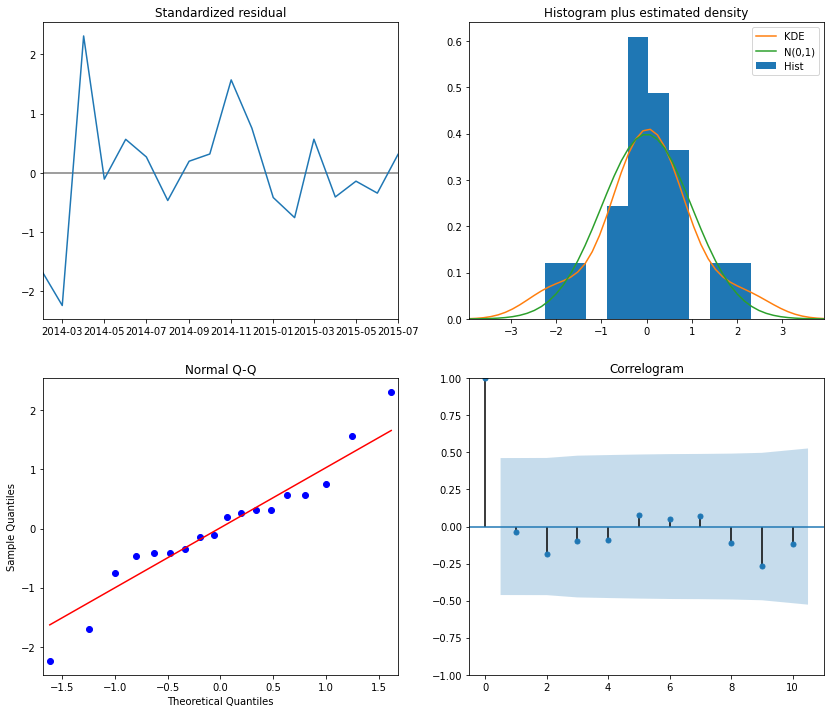

In [ ]:

result_c.plot_diagnostics(figsize=(14,12))
plt.show()

In [ ]:
pred_arima_c = result_c.get_prediction(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2015-07-01'),dynamic = False) 

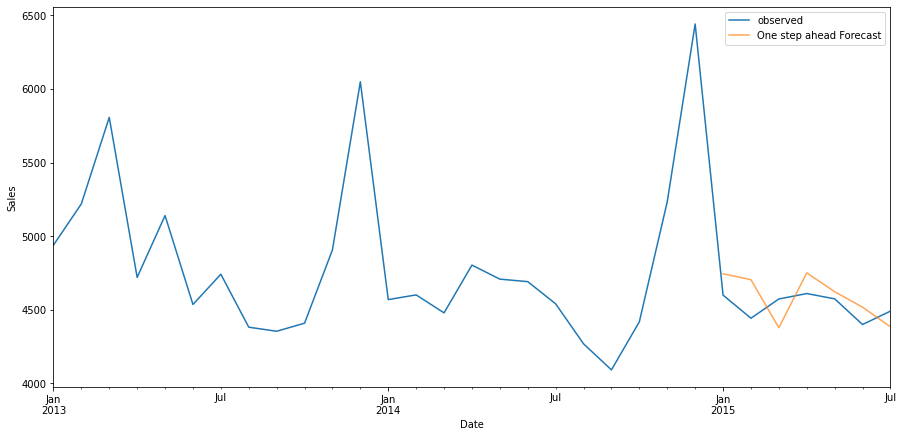

In [ ]:
ax = train_arima_c["2013":].plot(label = "observed", figsize=(15, 7))
pred_arima_c.predicted_mean.plot(ax = ax, label = "One step ahead Forecast", alpha = 0.7)
#ax.fill_between(pred_i.index, 
               #pred_i.iloc[:, 0], 
                #pred_i.iloc[:, 1], 
                #color = "k", alpha = 0.2)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend()
plt.show()

arima_forecasted_c = pred_arima_c.predicted_mean
arima_truth_c =  train_arima_c["2015-01-1":"2015-07-01"]

In [ ]:
pred_future_c = result_c.get_forecast(steps=12)

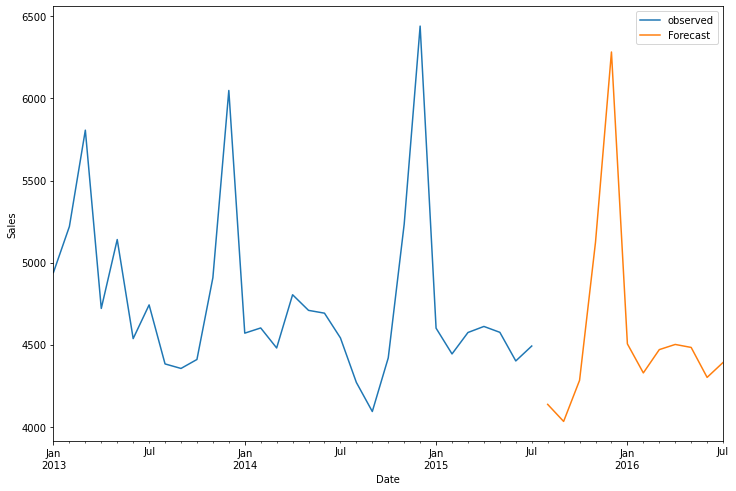

In [ ]:
pred_ci = pred_future_c.conf_int()
future_c = train_arima_c.plot(label='observed', figsize=(12, 8))
pred_future_c.predicted_mean.plot(ax=future_c , label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
future_c .set_xlabel('Date')
future_c .set_ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
mse_error = mean_squared_error(arima_forecasted_c, arima_truth_c)
print("mean squared value is {}". format(mse_error))

mean squared value is 24966.40082969431


In [ ]:
rms_arima_c = sqrt(mean_squared_error(arima_forecasted_c, arima_truth_c))
print("Root mean squared error value is {}". format(rms_arima_c))

NameError: ignored

In [ ]:
rms_arima_c = np.sqrt(((arima_forecasted_c - arima_truth_c) ** 2).mean())
print("Root mean squared error value is {}". format(rms_arima_c))

Root mean squared error value is 158.00761522701927


In [ ]:
mape_c = np.mean(np.abs((arima_truth_c - arima_forecasted_c)/arima_truth_c))*100
print(mape_c)

3.2082092044780164


Store Type D

In [ ]:
train_arima_d= train_sale_d.resample(rule='MS').mean()

In [ ]:
model_d = SARIMAX(train_arima_d,order = (7,2,1),seasonal_order = (1,0,0,12))
result_d = model_d.fit()
result_d.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(7, 2, 1)x(1, 0, 0, 12)   Log Likelihood                -169.311
Date:                            Wed, 05 Jan 2022   AIC                            358.623
Time:                                    19:04:46   BIC                            372.296
Sample:                                01-01-2013   HQIC                           362.905
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2566      0.263     -4.779      0.000      -1.772      -0.741
ar.L2         -1.3936      0.356     -3.919      0.000      -2.091      -0.697
ar.L3         -1.8290      0.476     -3.843      0.000      -2.762      -0.896
ar.L4         -1.6620      0.673     -2.471      0.013      -2.980      -0.344
ar.L5         -1.2609      0.505     -2.495      0.013      -2.251      -0.270
ar.L6         -1.2085      0.380     -3.176      0.001      -1.954      -0.463
ar.L7         -0.6811      0.402     -1.694      0.090      -1.469       0.107
ma.L1         -0.9432      0.498     -1.895      0.058      -1.919       0.032
ar.S.L12      -0.3925      0.590     -0.665      0.506      -1.549       0.764
sigma2      3.744e+04   2.78e+04      1.348      0.178    -1.7e+04    9.19e+04
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.38
Prob(Q):                               nan   Prob(JB):                         0.83
Heteroskedasticity (H):               0.36   Skew:                            -0.25
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

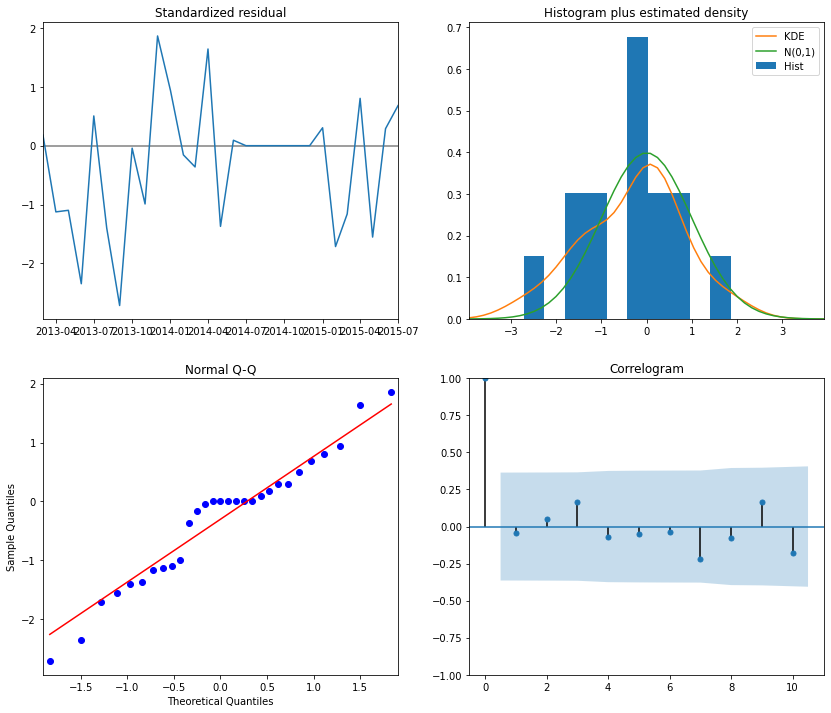

In [ ]:
result_d.plot_diagnostics(figsize=(14,12))
plt.show()

In [ ]:
pred_arima_d = result_d.get_prediction(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2015-07-01'),dynamic = False) 

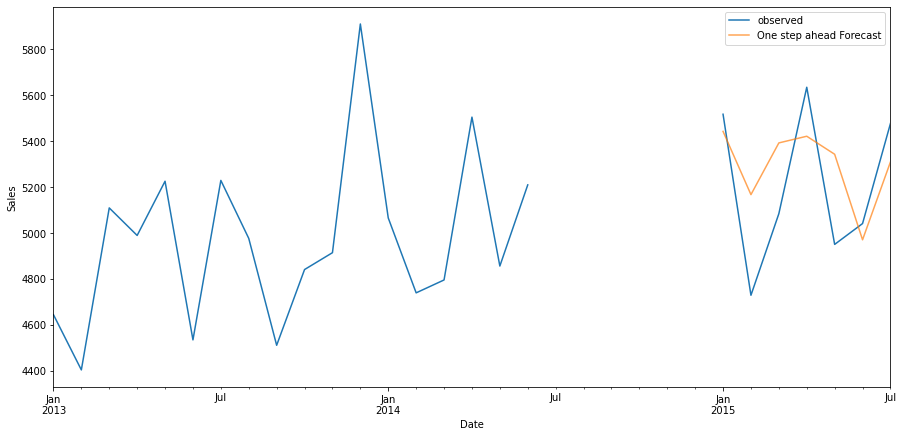

In [ ]:
ax = train_arima_d["2013":].plot(label = "observed", figsize=(15, 7))
pred_arima_d.predicted_mean.plot(ax = ax, label = "One step ahead Forecast", alpha = 0.7)
#ax.fill_between(pred_i.index, 
               #pred_i.iloc[:, 0], 
                #pred_i.iloc[:, 1], 
                #color = "k", alpha = 0.2)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend()
plt.show()

arima_forecasted_d = pred_arima_d.predicted_mean
arima_truth_d =  train_arima_d["2015-01-1":"2015-07-01"]

In [ ]:
pred_future_d = result_d.get_forecast(steps=12)

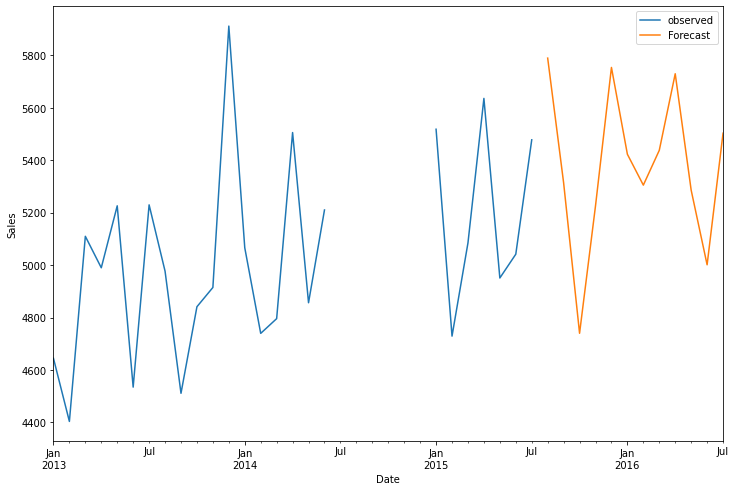

In [ ]:
pred_ci = pred_future_d.conf_int()
future_d = train_arima_d.plot(label='observed', figsize=(12, 8))
pred_future_d.predicted_mean.plot(ax=future_d , label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
future_d .set_xlabel('Date')
future_d .set_ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
rms_arima_d = np.sqrt(((arima_forecasted_d - arima_truth_d) ** 2).mean())
print("Root mean squared error value is {}". format(rms_arima_d))

Root mean squared error value is 274.0812896601113


In [ ]:
mape_d = np.mean(np.abs((arima_truth_d - arima_forecasted_d)/arima_truth_d))*100
print(mape_d)

4.696401667433099


In [ ]:
!pip install prophet

In [ ]:
from fbprophet import Prophet

In [ ]:
fb_a = train_sale_a.resample(rule='MS').mean()


In [ ]:
fb_a = pd.DataFrame(fb_a)

In [ ]:
fb_a.reset_index(level=0, inplace=True)

In [ ]:
fb_a['Date'] = pd.to_datetime(fb_a['Date'])

In [ ]:
fb_a = fb_a.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})

In [ ]:
train_prophet = df_train.copy()
train_prophet.reset_index(level=0, inplace=True)

In [ ]:
type(train_prophet)

In [ ]:
#school_holiday = train_prophet[train_prophet['SchoolHoliday']==1].loc[ : ,'Date']

In [ ]:
#type(school_holiday)

In [ ]:
#state_holiday = train_prophet[(train_prophet['StateHoliday']== 'a') | (train_prophet['StateHoliday']== 'b') | (train_prophet['StateHoliday']== 'c')].loc[ : ,'Date']

In [ ]:
#holidays = pd.concat((state_holiday, school_holiday))      
#holidays.head()

In [ ]:
state_holiday = train_prophet[(train_prophet.StateHoliday == 'a') | (train_prophet.StateHoliday == 'b') & (train_prophet.StateHoliday == 'c')].loc[:, 'Date'].values
school_holiday = train_prophet[train_prophet.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_holiday)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_holiday)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [ ]:
train_fb = fb_a[:24]


In [ ]:
test_fb = fb_a[24:]

In [ ]:
test_fb

,ds,y
24,2015-01-01,4903.769231
25,2015-02-01,4753.250000
26,2015-03-01,5175.923077
27,2015-04-01,5042.166667
28,2015-05-01,5023.260870
29,2015-06-01,5107.692308
30,2015-07-01,4954.259259


In [ ]:
m = Prophet(interval_width=0.95,holidays=holidays)

In [ ]:
m.fit(train_fb)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


In [ ]:
future = m.make_future_dataframe(periods=7,freq='MS')
forecast = m.predict(future)

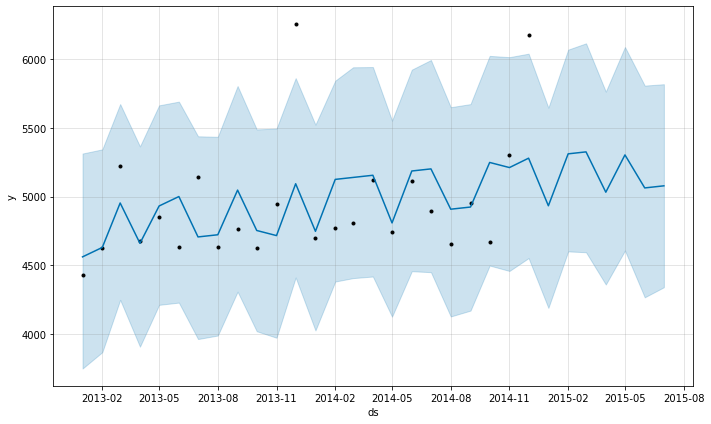

In [ ]:
m.plot(forecast);

In [ ]:
predictions = forecast.iloc[-7:]['yhat']

In [ ]:
predictions

24    4933.537590
25    5311.449563
26    5325.714642
27    5032.346307
28    5303.835462
29    5063.423802
30    5078.707816
Name: yhat, dtype: float64

In [ ]:
rmse(predictions,test_fb['y'])

248.18659602163717

In [ ]:
np.mean(np.abs((test_fb['y']- predictions)/test_fb['y']))*100

3.4862167597597935

Store type b

In [ ]:
fb_b = train_sale_b.resample(rule='MS').mean()

In [ ]:
train_sale_a

Date
2015-07-31    6064.0
2015-07-30    5567.0
2015-07-29    6402.0
2015-07-28    5671.0
2015-07-27    6627.0
               ...  
2013-01-07    6775.0
2013-01-05    2342.0
2013-01-04    4484.0
2013-01-03    4159.0
2013-01-02    4422.0
Name: Sales, Length: 784, dtype: float64

In [ ]:
fb_b = pd.DataFrame(fb_b)

In [ ]:
fb_b.reset_index(level=0, inplace=True)

In [ ]:
fb_b['Date'] = pd.to_datetime(fb_b['Date'])

In [ ]:
fb_b = fb_b.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})

In [ ]:
train_fb_b = fb_b[:24]

In [ ]:
test_fb_b = fb_b[24:]

In [ ]:
m_b = Prophet(interval_width=0.95,holidays=holidays)

In [ ]:

m_b.fit(train_fb_b)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


In [ ]:
future_b = m_b.make_future_dataframe(periods=7,freq='MS')
forecast_b = m_b.predict(future_b)

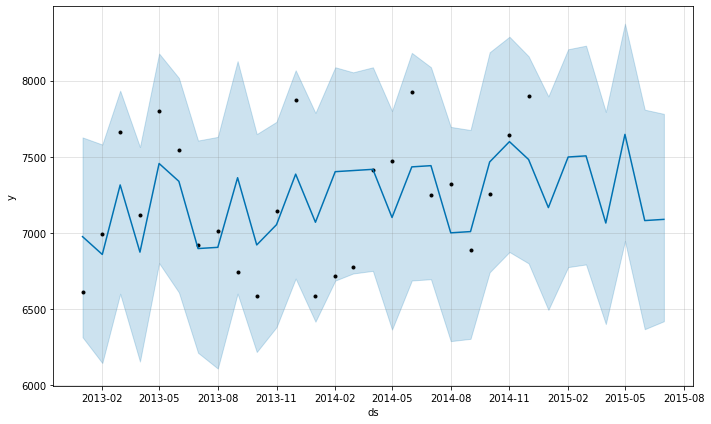

In [ ]:
m_b.plot(forecast_b);

In [ ]:
predictions_b = forecast_b.iloc[-7:]['yhat']

In [ ]:
rmse(predictions_b,test_fb_b['y'])

422.7059004092677

In [ ]:
np.mean(np.abs((test_fb_b['y']- predictions_b)/test_fb_b['y']))*100

4.2942332531022736

Store Type c

In [ ]:
fb_c = train_sale_c.resample(rule='MS').mean()

In [ ]:
fb_c = pd.DataFrame(fb_c)

In [ ]:
fb_c.reset_index(level=0, inplace=True)

In [ ]:
fb_c['Date'] = pd.to_datetime(fb_c['Date'])

In [ ]:
fb_c = fb_c.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})

In [ ]:
train_fb_c = fb_c[:24]

In [ ]:
test_fb_c = fb_c[24:]

In [ ]:
m_c = Prophet(interval_width=0.95,holidays=holidays)

In [ ]:
m_c.fit(train_fb_c)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


In [ ]:
future_c = m_c.make_future_dataframe(periods=7,freq='MS')
forecast_c = m_c.predict(future_c)

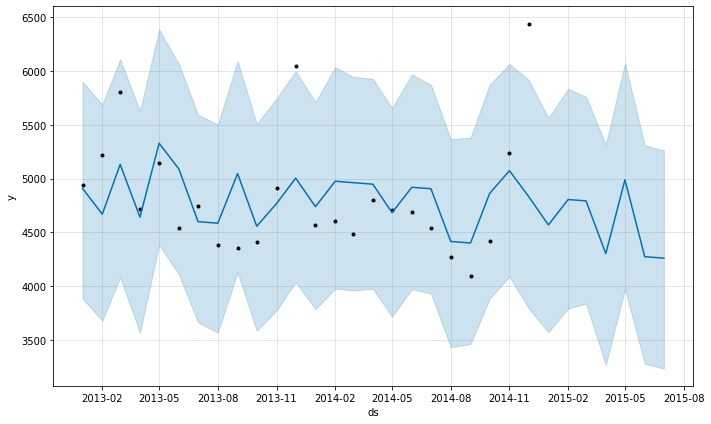

In [ ]:
m_c.plot(forecast_c);

In [ ]:
predictions_c = forecast_c.iloc[-7:]['yhat']

In [ ]:
rmse(predictions_c,test_fb_c['y'])

271.58982157787017

In [ ]:
np.mean(np.abs((test_fb_c['y']- predictions_c)/test_fb_c['y']))*100

5.346557744932817

Store Type D


In [ ]:
fb_d = train_sale_d.resample(rule='MS').mean()

In [ ]:
fb_d = pd.DataFrame(fb_d)

In [ ]:
fb_d.reset_index(level=0, inplace=True)

In [ ]:
fb_d['Date'] = pd.to_datetime(fb_d['Date'])

In [ ]:
fb_d = fb_d.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})

In [ ]:
train_fb_d = fb_d[:24]

In [ ]:
test_fb_d = fb_d[24:]

In [ ]:
m_d = Prophet(interval_width=0.95,holidays=holidays)

In [ ]:
m_d.fit(train_fb_d)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


In [ ]:
future_d = m_d.make_future_dataframe(periods=7,freq='MS')
forecast_d = m_d.predict(future_d)

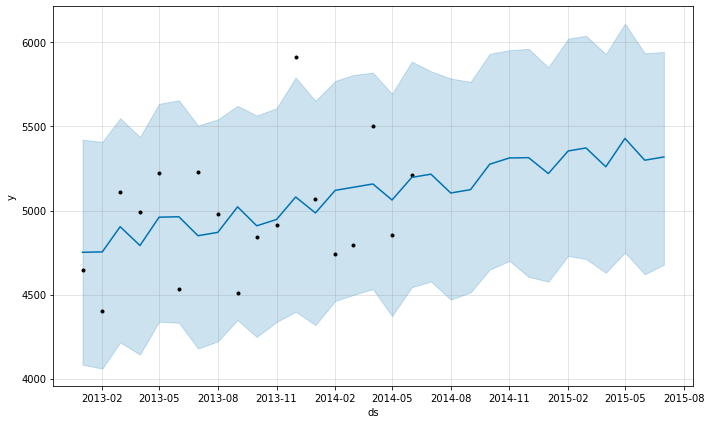

In [ ]:
m_d.plot(forecast_d);

In [ ]:
predictions_d = forecast_d.iloc[-7:]['yhat']

In [ ]:
rmse(predictions_d,test_fb_d['y'])

382.4609588935532

In [ ]:
np.mean(np.abs((test_fb_d['y']- predictions_d)/test_fb_d['y']))*100

6.945531182378492